# Visualize version 3

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class VisualizeTestPred:
    def __init__(self, test_url, real_url):
        section_name_map = {
            "Project Description / Purpose": "Project Description",
            "Project Overview": "Project Overview",
            "Timeline": "Timeline",
            "Project Scope": "Project Scope",
            "Project Team": "Project Team"
        }
        self.test_url = test_url
        self.real_url = real_url

        self.real_df = pd.read_csv(self.real_url)
        self.real_df = self.real_df.rename(columns={'description': 'Section'})
        self.real_df = self.real_df[['user_id','Section','score', 'grader_name', 'grader_comment']]

        self.test_df = pd.read_csv(self.test_url)
        self.test_df = self.test_df.rename(columns={'File_Name': 'user_id'})
        self.test_df['Section'] = self.test_df['Section'].replace(section_name_map)

        self.merged_df = pd.merge(self.test_df, self.real_df, on=['user_id', 'Section'], how='left')
        self.merged_df = self.merged_df.rename(columns={'score': 'Real_Grade'})

        self.pred_true = self.aggregateTestRealResult(self.test_url, self.real_url)

    def aggregateTestRealResult(self, test_results_url, real_results_url):
        section_name_map = {
            "Project Description / Purpose": "Project Description",
            "Project Overview": "Project Overview",
            "Timeline": "Timeline",
            "Project Scope": "Project Scope",
            "Project Team": "Project Team"
        }
        result_df = pd.read_csv(test_results_url, index_col=0).reset_index(drop=True)
        result_df = result_df.drop_duplicates(subset=['File_Name','Section', 'Criteria'], keep='first').reset_index(drop=True)
        print("Number of unique file: ", result_df['File_Name'].nunique())
        grouped_df = result_df.groupby(['File_Name', 'Section']).agg({
            'AI_Grade': 'sum',
            'Comment': lambda x: ' '.join(x)
        }).reset_index()

        # Display the resulting DataFrame
        grouped_df['Section'] = grouped_df['Section'].replace(section_name_map)
        final_test_df = grouped_df[['File_Name', 'Section', 'AI_Grade', 'Comment']]
        final_test_df = final_test_df.rename(columns={'File_Name': 'user_id'})

        final_true_df = pd.read_csv(real_results_url)
        final_true_df = final_true_df.rename(columns={'description': 'Section'})

        final_trainig_df = pd.merge(final_test_df, final_true_df, on=['user_id', 'Section'], how='left')
        final_trainig_df = final_trainig_df.rename(columns={'Comment': 'AI_Comment'})
        return final_trainig_df
    
    def check_grades(self, section=None, criteria=None):
        is_wrong = []
        temp_df = self.merged_df.copy()
        if section != None:
            temp_df = temp_df[temp_df['Section'] == section]
            if criteria != None:
                temp_df = temp_df[temp_df['Criteria'] == criteria]
        for index, row in temp_df.iterrows():
            if row['AI_Grade'] != row['Real_Grade']:
                if row['user_id'] not in is_wrong:
                    print("-" * 40)
                    is_wrong.append(row['user_id'])
                    print(f"User ID: {row['user_id']}")
                print(f"\nSection: {row['Section']}")
                print(f"Criteria: {row['Criteria']}")
                print(f"AI Grade: {row['AI_Grade']}")
                print(f"AI Comment: {row['Comment']}")
                print(f"Human Grade: {row['Real_Grade']}")
                print(f"Human Comment: {row['grader_comment']}")
    
    def plot_failed_submissions(self, section=None):
        is_wrong = []
        temp_df = self.merged_df.copy()
        
        if section != None:
            temp_df = temp_df[temp_df['Section'] == section]
        print("Number of file: ", temp_df['user_id'].nunique())
        failed_submissions_id = temp_df[temp_df['Real_Grade'] == 0]['user_id'].unique()
        for id in failed_submissions_id:
            print("-" * 40)
            failed_id_df = temp_df[temp_df['user_id'] == id]
            print(f"user id: {id}")
            print(f"Human Grade: {failed_id_df['Real_Grade'].iloc[0]}")
            print(f"Human Comment: {failed_id_df['grader_comment'].iloc[0]}")
            for index, row in failed_id_df.iterrows():
                print(f"\nSection: {row['Section']}")
                print(f"Criteria: {row['Criteria']}")
                print(f"AI Grade: {row['AI_Grade']}")
                print(f"AI Comment: {row['Comment']}")
    
    def visualize_difference_between_AI_and_Real_Grade(self, section):
        result_df = self.pred_true
        result_df.rename(columns={'score': 'Real_Grade', 'long_description': 'Criteria'}, inplace=True)
        visualize_df = result_df[['user_id', 'Section', 'Criteria', 'AI_Grade', 'Real_Grade', 'grader_name']]
        description_df = visualize_df[visualize_df['Section'] == section]
        # Separate the data into two DataFrames based on RealGrade
        real_grade_0 = description_df[description_df['Real_Grade'] == 0]
        real_grade_1 = description_df[description_df['Real_Grade'] == 1]

        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
        fig.suptitle('Difference between AI and Real Grade for Section ' + section, fontsize=20)
        # Scatter plot for RealGrade = 0
        sns.scatterplot(ax=axes[0], x=real_grade_0.index, y=real_grade_0['AI_Grade'], color='blue')
        axes[0].set_title('AI grade when RealGrade = 0')
        axes[0].set_xlabel('Submission Index')
        axes[0].set_ylabel('AI grade')

        # Scatter plot for RealGrade = 1
        sns.scatterplot(ax=axes[1], x=real_grade_1.index, y=real_grade_1['AI_Grade'], color='green')
        axes[1].set_title('AI grade when RealGrade = 1')
        axes[1].set_xlabel('Submission Index')

    def plot_false_positive(self, section):
        # Get the false positive data
        result_df = self.pred_true
        result_df.rename(columns={'score': 'Real_Grade', 'long_description': 'Criteria'}, inplace=True)
        visualize_df = result_df[['user_id', 'Section', 'Criteria', 'AI_Grade', 'Real_Grade', 'grader_comment', 'AI_Comment']]
        description_df = visualize_df[visualize_df['Section'] == section]
        false_positive = description_df[(description_df['AI_Grade'] == max(visualize_df['AI_Grade'])) & (description_df['Real_Grade'] == 0)]
        false_positive = false_positive.sort_values(by='AI_Grade', ascending=False)
        false_positive_id = false_positive['user_id'].unique()

        # From false positive ID print out the information
        temp_df = self.merged_df.copy()
        if section != None:
            temp_df = temp_df[temp_df['Section'] == section]
        print("Number of false positive: ", false_positive['user_id'].nunique())
        for id in false_positive_id:
            print("-" * 40)
            false_positive_df = temp_df[temp_df['user_id'] == id]
            print(f"user id: {id}")
            print(f"Human Grade: {false_positive_df['Real_Grade'].iloc[0]}")
            print(f"Human Comment: {false_positive_df['grader_comment'].iloc[0]}")
            for index, row in false_positive_df.iterrows():
                print(f"\nSection: {row['Section']}")
                print(f"Criteria: {row['Criteria']}")
                print(f"AI Grade: {row['AI_Grade']}")
                print(f"AI Comment: {row['Comment']}")

    def plot_false_negative(self, section):
        # Get the false negative data
        result_df = self.pred_true
        result_df.rename(columns={'score': 'Real_Grade', 'long_description': 'Criteria'}, inplace=True)
        visualize_df = result_df[['user_id', 'Section', 'Criteria', 'AI_Grade', 'Real_Grade', 'grader_comment', 'AI_Comment']]
        description_df = visualize_df[visualize_df['Section'] == section]
        false_negative = description_df[(description_df['AI_Grade'] < max(visualize_df['AI_Grade'])) & (description_df['Real_Grade'] == 1)]
        false_negative = false_negative.sort_values(by='AI_Grade', ascending=False)
        false_negative_id = false_negative['user_id'].unique()

        # From false negative ID print out the information
        temp_df = self.merged_df.copy()
        if section != None:
            temp_df = temp_df[temp_df['Section'] == section]
        print("Number of false positive: ", false_negative['user_id'].nunique())
        for id in false_negative_id:
            print("-" * 40)
            false_negative_df = temp_df[temp_df['user_id'] == id]
            print(f"user id: {id}")
            print(f"Human Grade: {false_negative_df['Real_Grade'].iloc[0]}")
            print(f"Human Comment: {false_negative_df['grader_comment'].iloc[0]}")
            for index, row in false_negative_df.iterrows():
                print(f"\nSection: {row['Section']}")
                print(f"Criteria: {row['Criteria']}")
                print(f"AI Grade: {row['AI_Grade']}")
                print(f"AI Comment: {row['Comment']}")


In [158]:
test_url = 'test_results/test_result_on_56_files_0_1.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)
visualizer.check_grades('Project Description')

Number of unique file:  56
----------------------------------------
User ID: 593636371

Section: Project Description
Criteria: Question 5. Does the value of the 'TIP 2.0 Process Milestone:' attribute provide specific process milestone details?
AI Grade: 0
AI Comment: The value does not provide specific process milestone details.
Human Grade: 1.0
Human Comment: I see a clear project description and purpose statement with enough detail.


Section: Project Description
Criteria: Question 8. Does the value of the 'Project Description / Purpose' attribute include detailed expected results from the project?
AI Grade: 0
AI Comment: The project description does not include detailed expected results from the project.
Human Grade: 1.0
Human Comment: I see a clear project description and purpose statement with enough detail.

----------------------------------------
User ID: 593636611

Section: Project Description
Criteria: Question 8. Does the value of the 'Project Description / Purpose' attribut

# Visualize version 3

In [159]:
result_df = pd.read_csv('56_files_pred_true_version3.csv')
# Rename columns
result_df.rename(columns={'score': 'Real_Grade', 'long_description': 'Criteria'}, inplace=True)
visualize_df = result_df[['user_id', 'Section', 'Criteria', 'AI_Grade', 'Real_Grade', 'grader_name']]
visualize_df

,user_id,Section,Criteria,AI_Grade,Real_Grade,grader_name
0,593636371,Project Description,Includes a brief description of the project.<b...,6,1.0,Kailey Love
1,593636371,Project Overview,Describes problem or performance gap with desc...,3,1.0,Kailey Love
2,593636371,Project Scope,Explains objectives that are in scope.<br/>\r\...,2,1.0,Kailey Love
3,593636371,Project Team,Identifies:<br/>\r\n<br/>\r\n1. Team Lead<br/>...,6,1.0,Kailey Love
4,593636371,Timeline,Lists each key task and planned completion dates.,2,1.0,Kailey Love
...,...,...,...,...,...,...
250,596799191,Project Description,Includes a brief description of the project.<b...,6,1.0,Samantha Basch
251,596799191,Project Overview,Describes problem or performance gap with desc...,3,1.0,Samantha Basch
252,596799191,Project Scope,Explains objectives that are in scope.<br/>\r\...,1,1.0,Samantha Basch
253,596799191,Project Team,Identifies:<br/>\r\n<br/>\r\n1. Team Lead<br/>...,7,1.0,Samantha Basch


## Visualize Description

### Mulltivariate graph

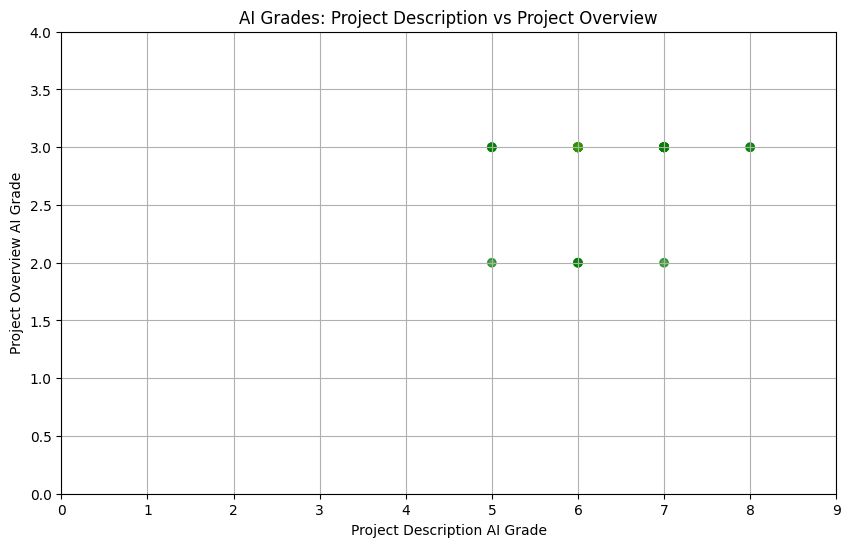

In [160]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_section_grades(section1, section2, csv_file='56_files_pred_true_version3.csv'):
    """
    Function to plot AI grades for two sections and color based on Real_Grade.
    
    Parameters:
    section1 (str): The first section name.
    section2 (str): The second section name.
    csv_file (str): The path to the CSV file containing the data.
    
    Returns:
    None
    """
    # Read the CSV file
    result_df = pd.read_csv(csv_file)
    
    # Rename columns
    result_df.rename(columns={'score': 'Real_Grade', 'long_description': 'Criteria'}, inplace=True)
    
    # Filter data for the specified sections
    filtered_df = result_df[result_df['Section'].isin([section1, section2])]
    
    # Pivot the DataFrame to have AI grades for the specified sections
    pivot_df = filtered_df.pivot(index='user_id', columns='Section', values='AI_Grade')
    
    # Drop rows with missing values
    pivot_df.dropna(inplace=True)
    
    # Merge the Real_Grade column back to the pivoted DataFrame
    real_grades = filtered_df.pivot(index='user_id', columns='Section', values='Real_Grade')
    pivot_df = pivot_df.merge(real_grades, on='user_id', suffixes=('_AI', '_Real'))
    
    # Define colors based on Real_Grade for the specified sections
    def get_color(row):
        if row[f'{section1}_Real'] == 1 and row[f'{section2}_Real'] == 1:
            return 'green'
        elif row[f'{section1}_Real'] == 1 or row[f'{section2}_Real'] == 1:
            return 'yellow'
        elif row[f'{section1}_Real'] == 0 and row[f'{section2}_Real'] == 0:
            return 'red'
        else:
            return 'gray'
    
    pivot_df['color'] = pivot_df.apply(get_color, axis=1)
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.scatter(pivot_df[f'{section1}_AI'], pivot_df[f'{section2}_AI'], c=pivot_df['color'], alpha=0.7)
    plt.title(f'AI Grades: {section1} vs {section2}')
    plt.xlabel(f'{section1} AI Grade')
    plt.ylabel(f'{section2} AI Grade')
    plt.xlim(0, pivot_df[f'{section1}_AI'].max() + 1)
    plt.ylim(0, pivot_df[f'{section2}_AI'].max() + 1)
    plt.grid(True)
    plt.show()

# Example usage
plot_section_grades('Project Description', 'Project Overview')

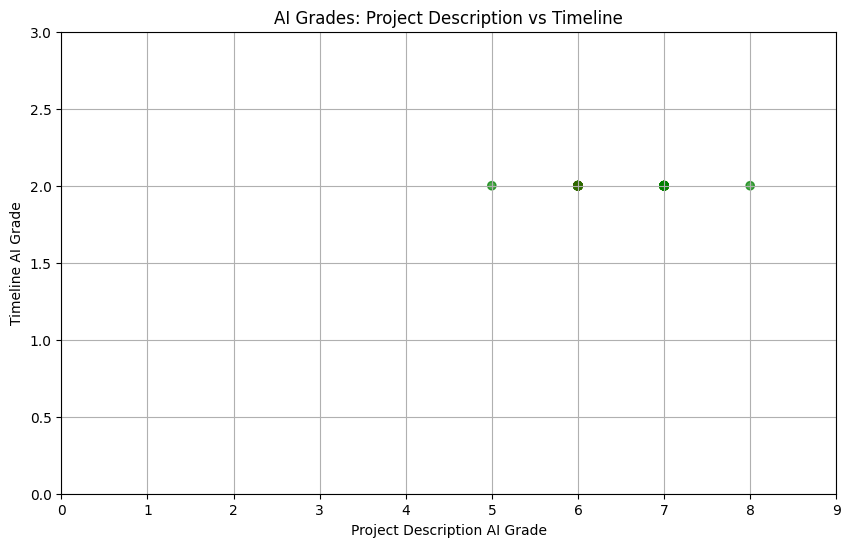

In [161]:
plot_section_grades('Project Description', 'Timeline')

### Histogram of AI score for each section

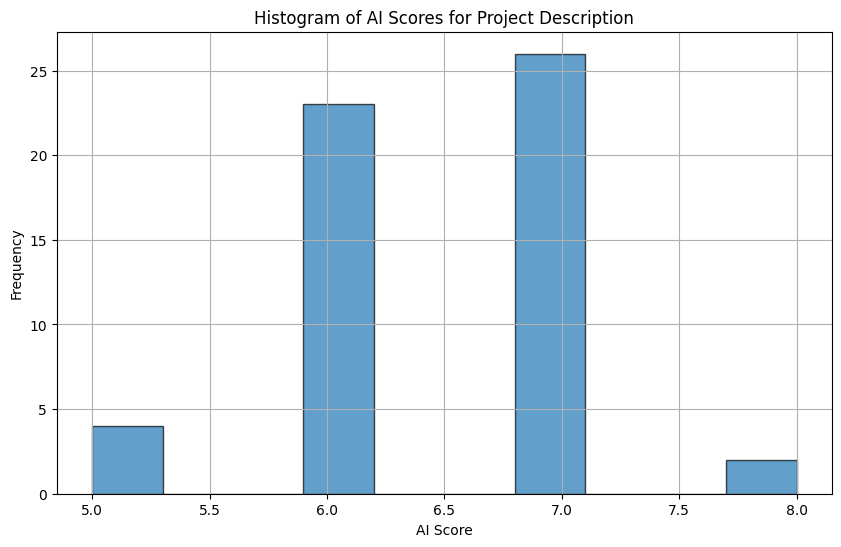

In [162]:
# Read the CSV file
def plot_section_histogram(section, url='56_files_pred_true_version3.csv'):
    """
    Function to plot a histogram of AI scores for a given section.
    
    Parameters:
    section (str): The section name.
    df (pd.DataFrame): The DataFrame containing the data.
    
    Returns:
    None
    """
    df = pd.read_csv(url)

    # Rename columns
    df.rename(columns={'score': 'Real_Grade', 'long_description': 'Criteria'}, inplace=True)
    # Filter data for the specified section
    section_df = df[df['Section'] == section]
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(section_df['AI_Grade'], bins=10, alpha=0.7, edgecolor='black')
    plt.title(f'Histogram of AI Scores for {section}')
    plt.xlabel('AI Score')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Example usage
plot_section_histogram('Project Description', '56_files_pred_true_version3.csv')

### AI difference for pass and fail submissions

In [163]:
def visualize_difference_between_AI_and_Real_Grade(url, section):
    result_df = pd.read_csv(url)
    result_df.rename(columns={'score': 'Real_Grade', 'long_description': 'Criteria'}, inplace=True)
    visualize_df = result_df[['user_id', 'Section', 'Criteria', 'AI_Grade', 'Real_Grade', 'grader_name']]
    description_df = visualize_df[visualize_df['Section'] == section]
    # Separate the data into two DataFrames based on RealGrade
    real_grade_0 = description_df[description_df['Real_Grade'] == 0]
    real_grade_1 = description_df[description_df['Real_Grade'] == 1]

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    fig.suptitle('Difference between AI and Real Grade for Section ' + section, fontsize=20)
    # Scatter plot for RealGrade = 0
    sns.scatterplot(ax=axes[0], x=real_grade_0.index, y=real_grade_0['AI_Grade'], color='blue')
    axes[0].set_title('AI grade when RealGrade = 0')
    axes[0].set_xlabel('Submission Index')
    axes[0].set_ylabel('AI grade')

    # Scatter plot for RealGrade = 1
    sns.scatterplot(ax=axes[1], x=real_grade_1.index, y=real_grade_1['AI_Grade'], color='green')
    axes[1].set_title('AI grade when RealGrade = 1')
    axes[1].set_xlabel('Submission Index')



### Visualize AI Grade only

Number of files: 56


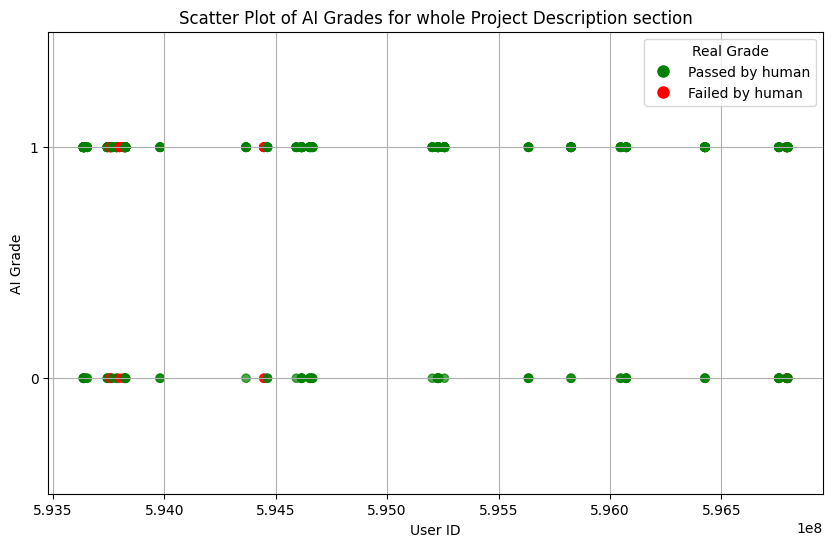

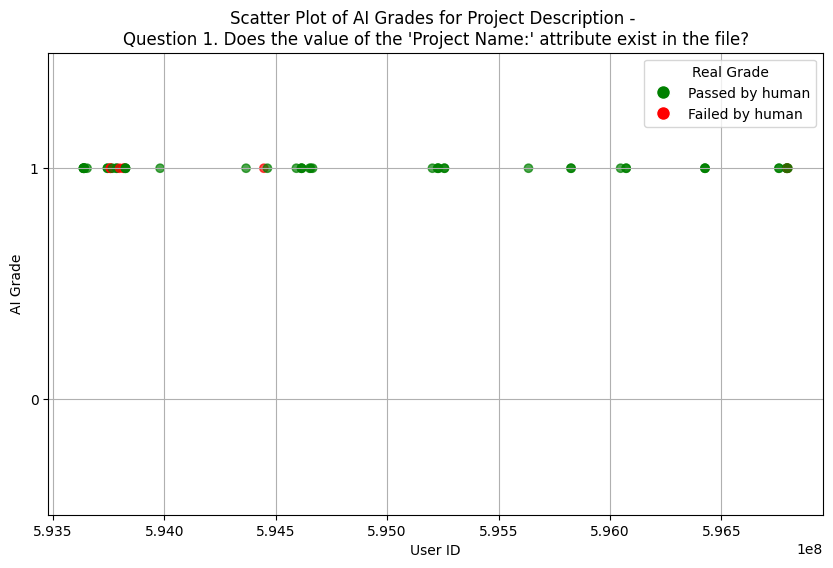

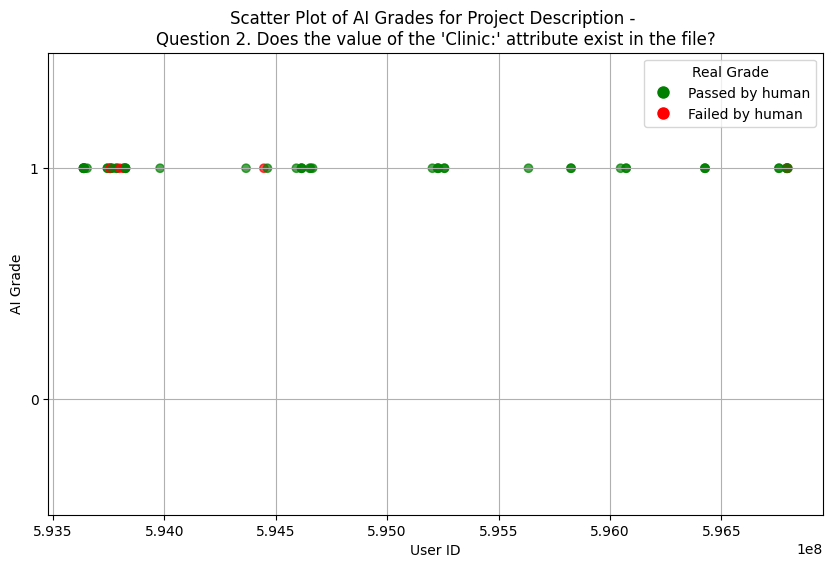

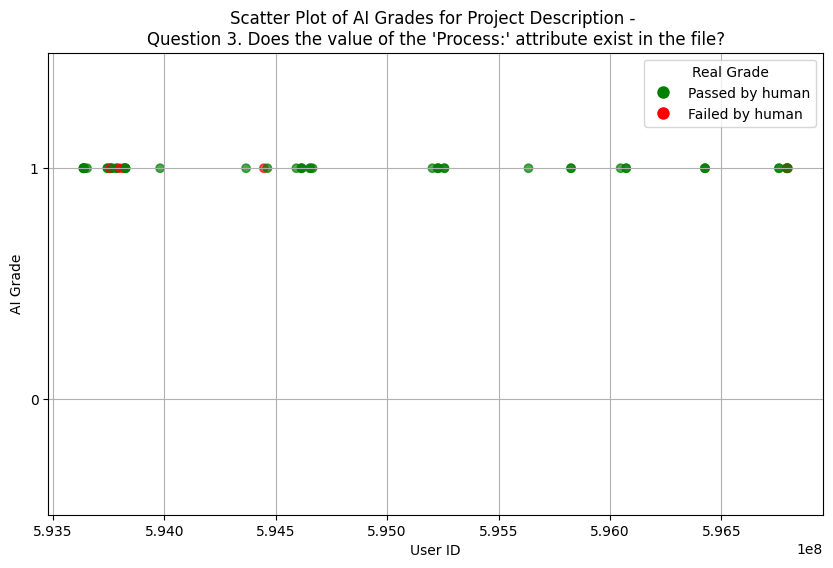

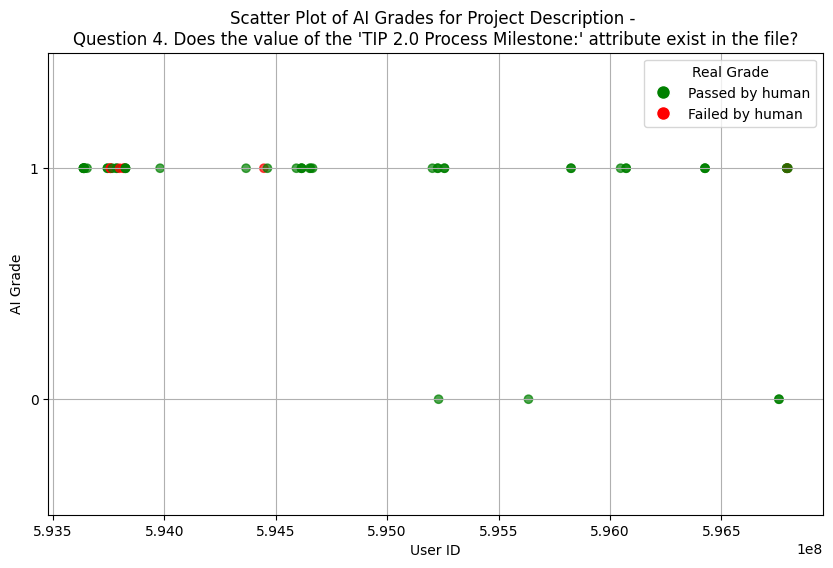

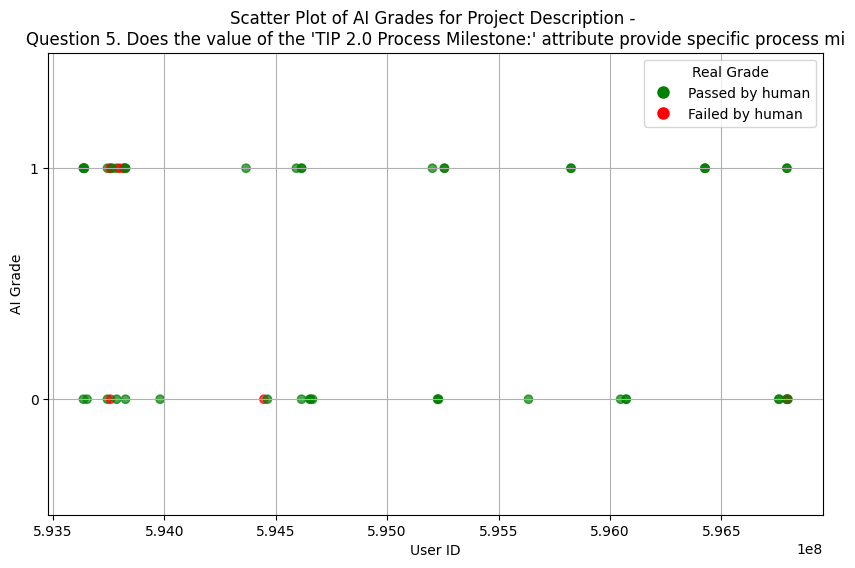

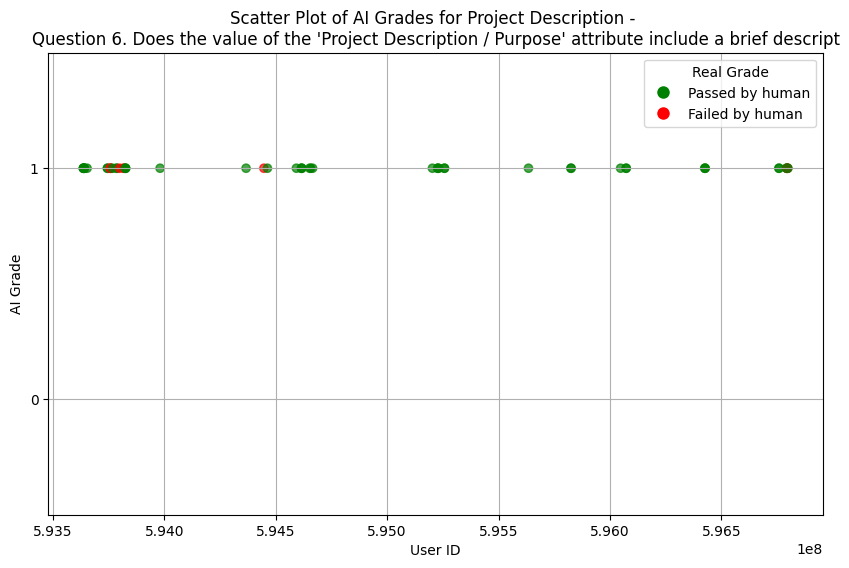

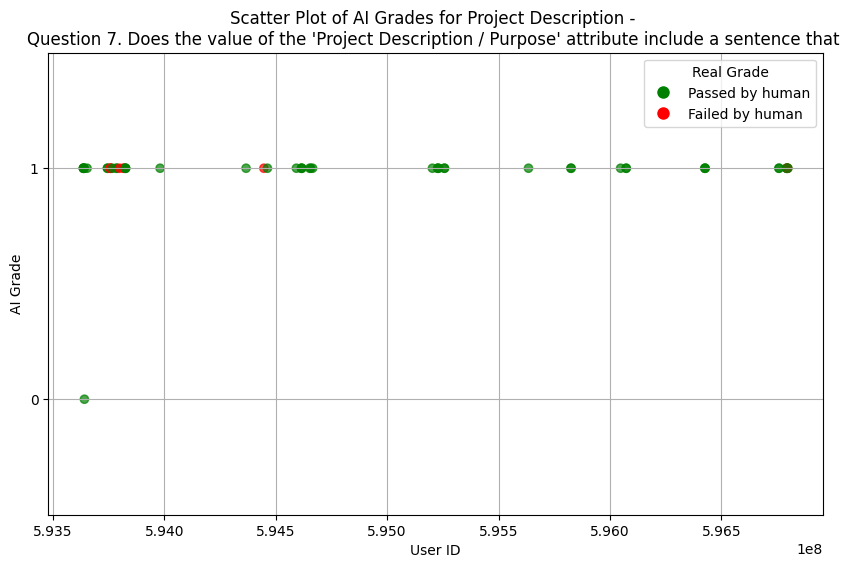

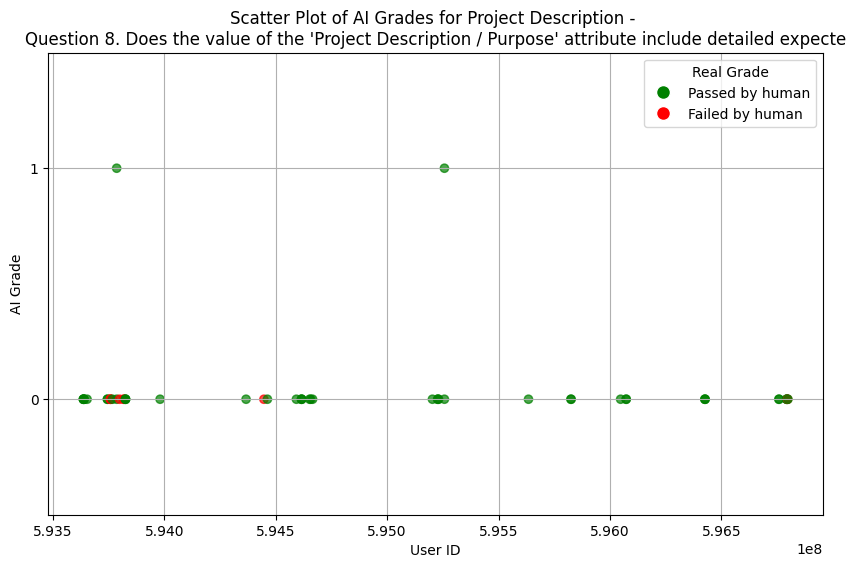

In [164]:
def plot_section_criteria_scatter(test_url,real_url,section):
    """
    Function to plot scatter plots of AI grades for each criteria within a given section.
    
    Parameters:
    section (str): The section name.
    df (pd.DataFrame): The DataFrame containing the data.
    
    Returns:
    None
    """
    section_name_map = {
        "Project Description / Purpose": "Project Description",
        "Project Overview": "Project Overview",
        "Timeline": "Timeline",
        "Project Scope": "Project Scope",
        "Project Team": "Project Team"
    }

    test_results = pd.read_csv(test_url, index_col=0).reset_index(drop=True)
    test_results = test_results.rename(columns={'File_Name': 'user_id'})
    test_results['Section'] = test_results['Section'].replace(section_name_map)

    real_results = pd.read_csv(real_url, index_col=0).reset_index(drop=True)
    real_results = real_results.rename(columns={'description': 'Section'})

    df = pd.merge(test_results, real_results[['user_id', 'Section', 'score']], on=['user_id', 'Section'], how='left')
    df = df.rename(columns={'score': 'Real_Grade'})

    print(f"Number of files: {df['user_id'].nunique()}")
    # Filter data for the specified section
    section_df = df[df['Section'] == section]

    # Get unique criteria for the section
    unique_criteria = section_df['Criteria'].unique()
    colors = section_df['Real_Grade'].apply(lambda x: 'green' if x == 1 else 'red')
    plt.figure(figsize=(10, 6))
    plt.scatter(section_df['user_id'], section_df['AI_Grade'], c=colors, alpha=0.7)
    plt.title(f'Scatter Plot of AI Grades for whole {section} section')
    plt.xlabel('User ID')
    plt.ylabel('AI Grade')
    plt.ylim(-0.5, 1.5)
    plt.yticks([0, 1])
    plt.grid(True)
    # Create a legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Passed by human'),
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Failed by human')]
    plt.legend(handles=handles, title='Real Grade')
    plt.show()
    
    # Plot scatter plot for each criteria
    for criteria in unique_criteria:
        criteria_df = section_df[section_df['Criteria'] == criteria]
        colors = criteria_df['Real_Grade'].apply(lambda x: 'green' if x == 1 else 'red')
        plt.figure(figsize=(10, 6))
        plt.scatter(criteria_df['user_id'], criteria_df['AI_Grade'], c=colors, alpha=0.7)
        plt.title(f'Scatter Plot of AI Grades for {section} - \n{criteria[:100]}')
        plt.xlabel('User ID')
        plt.ylabel('AI Grade')
        plt.ylim(-0.5, 1.5)
        plt.yticks([0, 1])
        plt.grid(True)
        # Create a legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Passed by human'),
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Failed by human')]
        plt.legend(handles=handles, title='Real Grade')
        plt.show()

# Example usage
test_url = 'test_results/test_result_on_56_files_0_1.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'
plot_section_criteria_scatter(test_url,real_url,'Project Description')

# Visualizer version 4 Description only

Number of files: 54


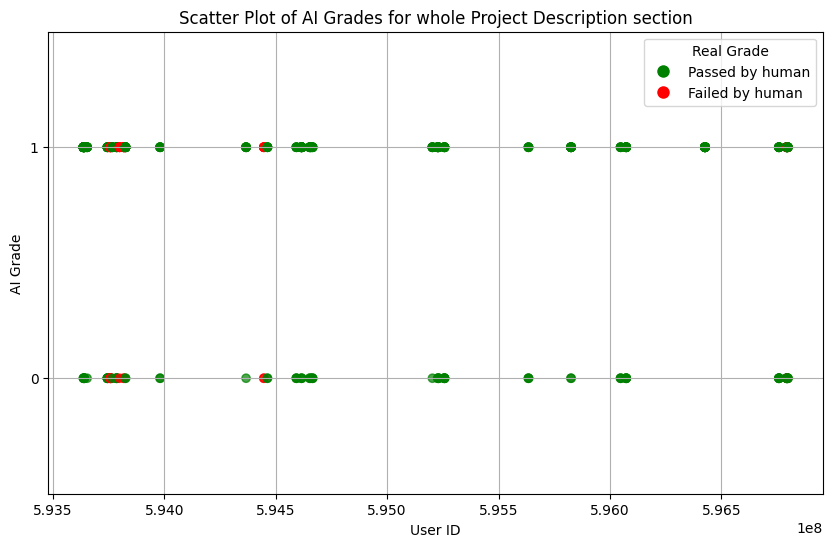

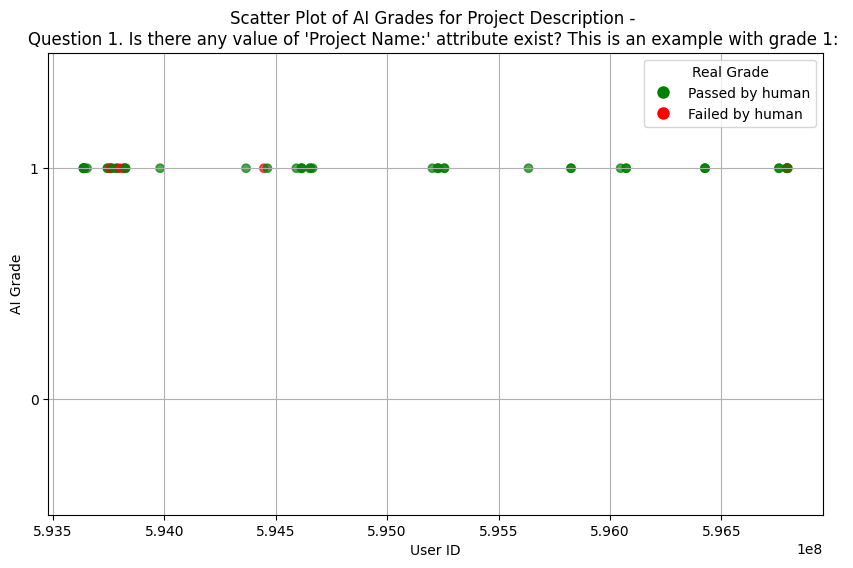

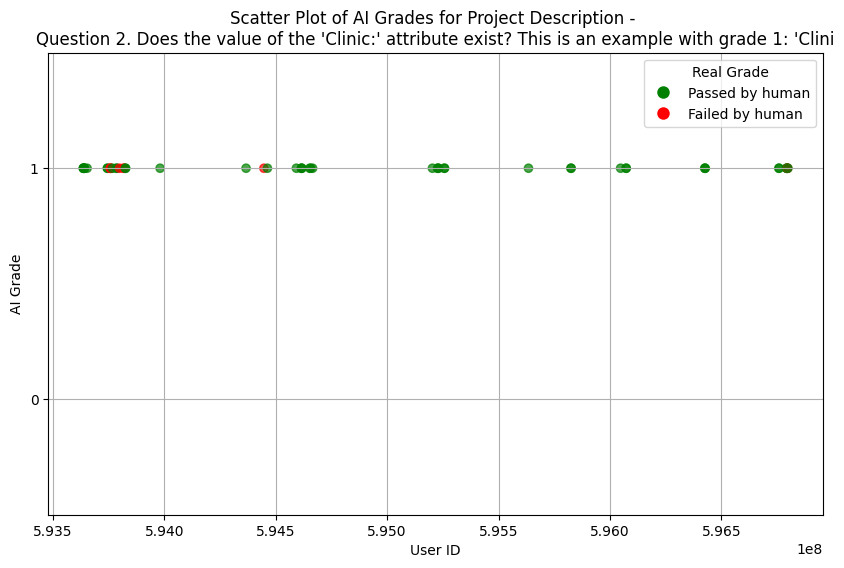

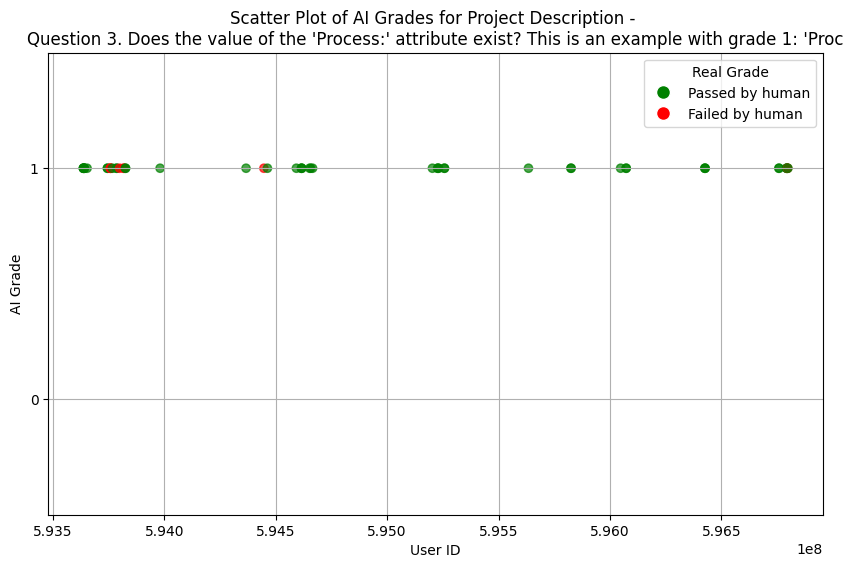

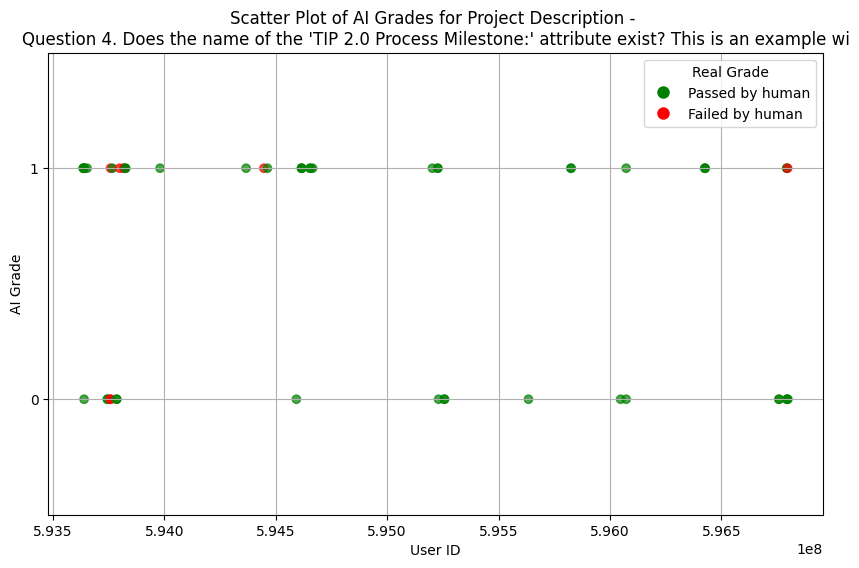

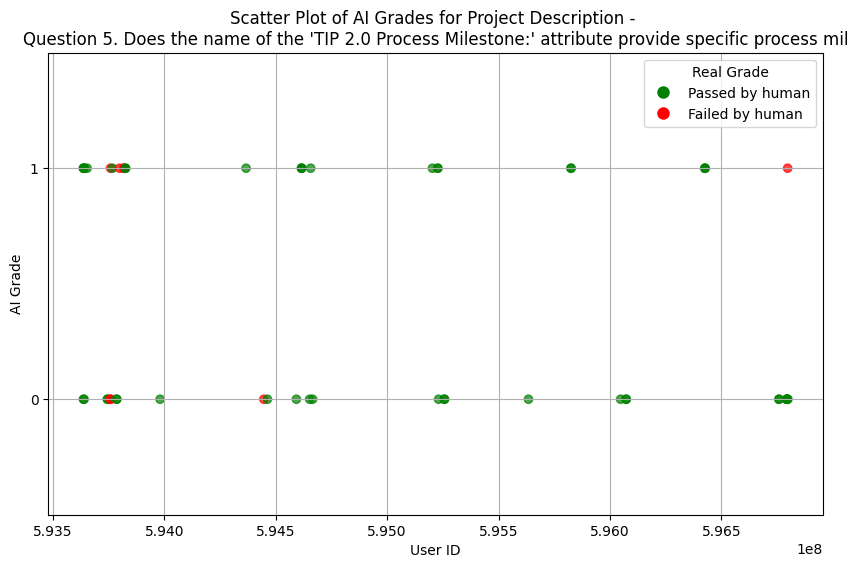

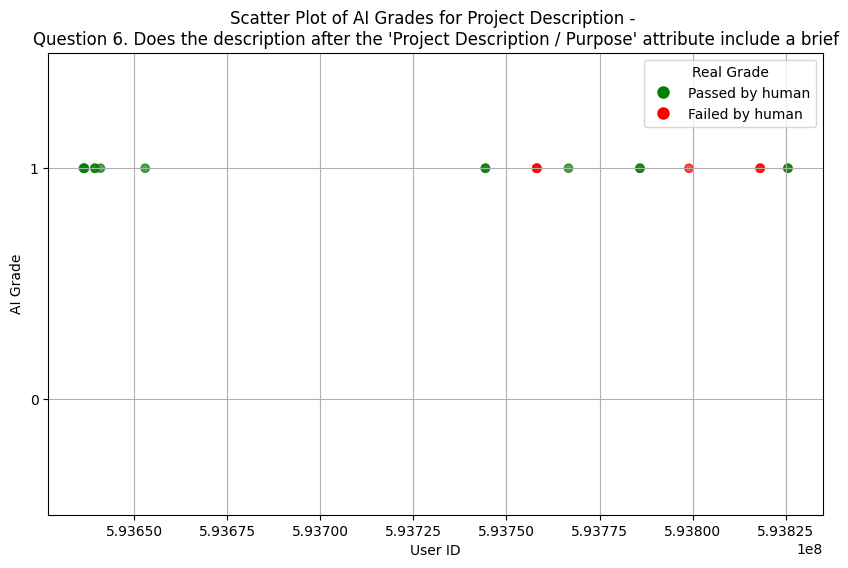

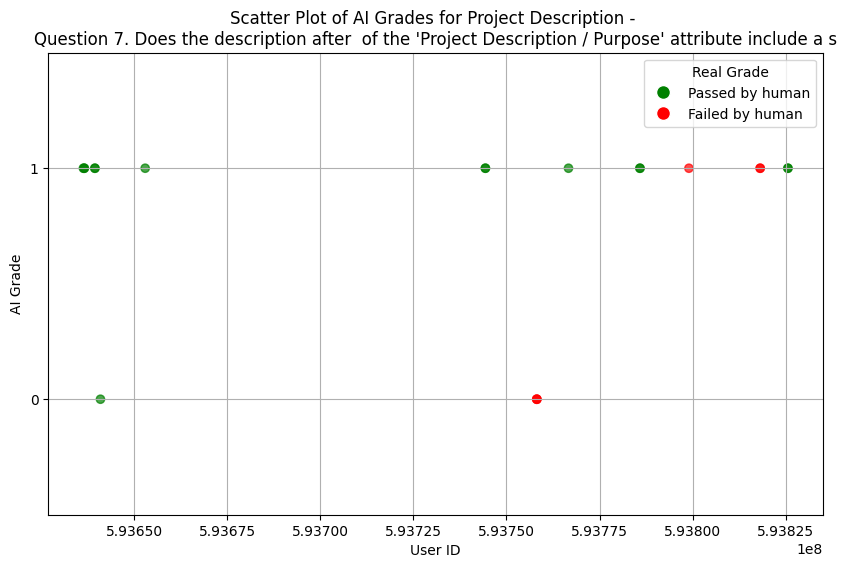

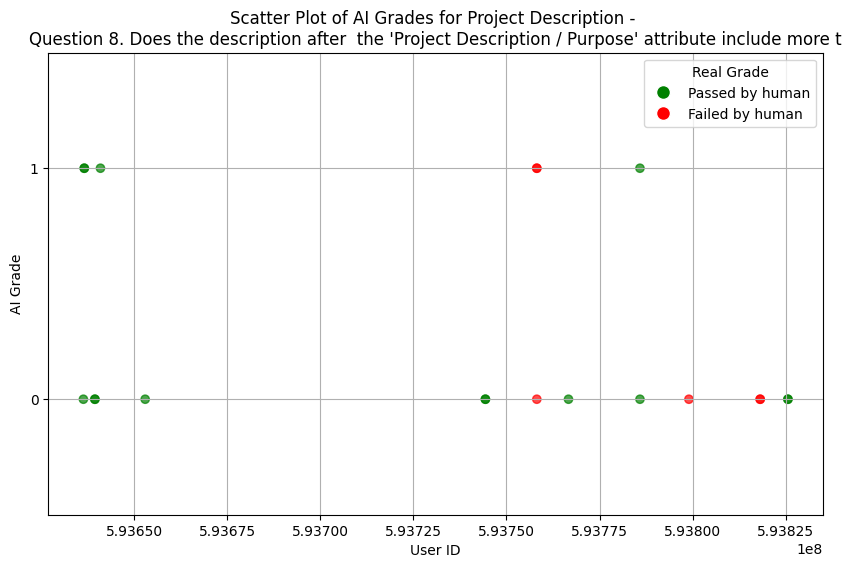

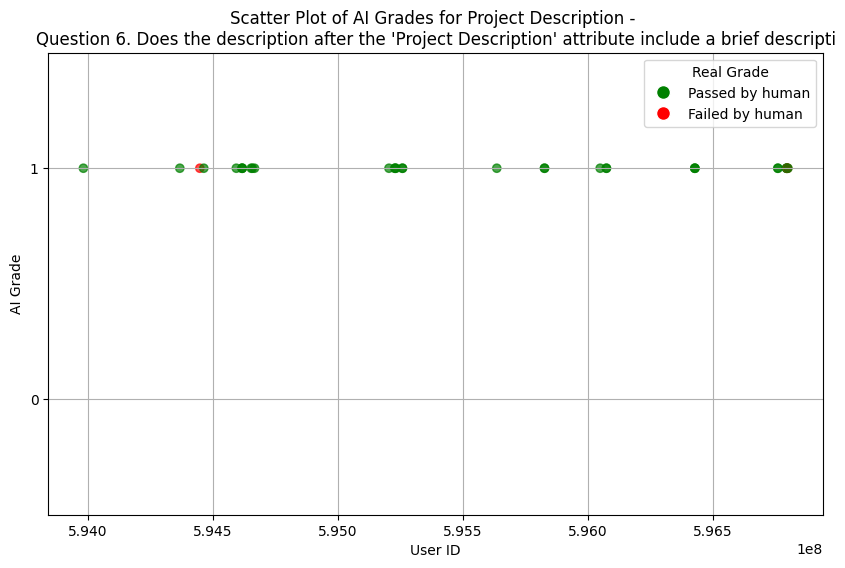

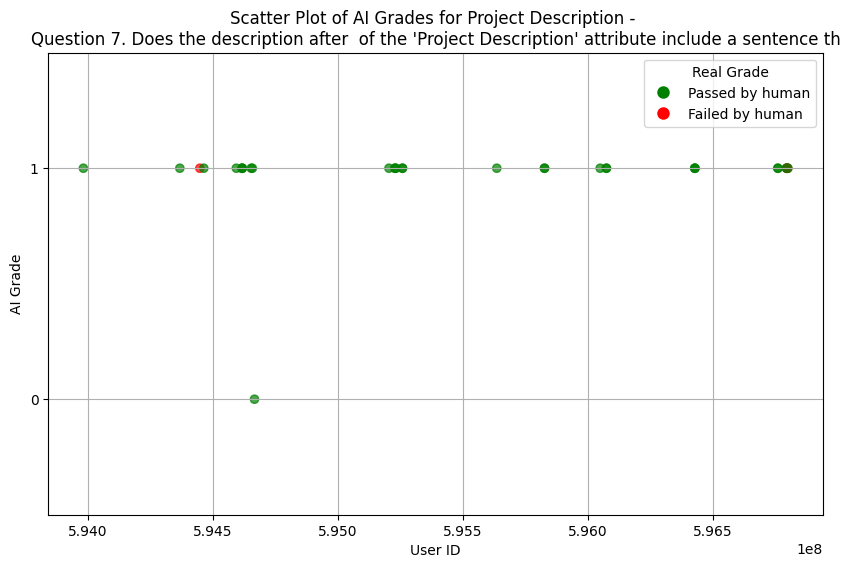

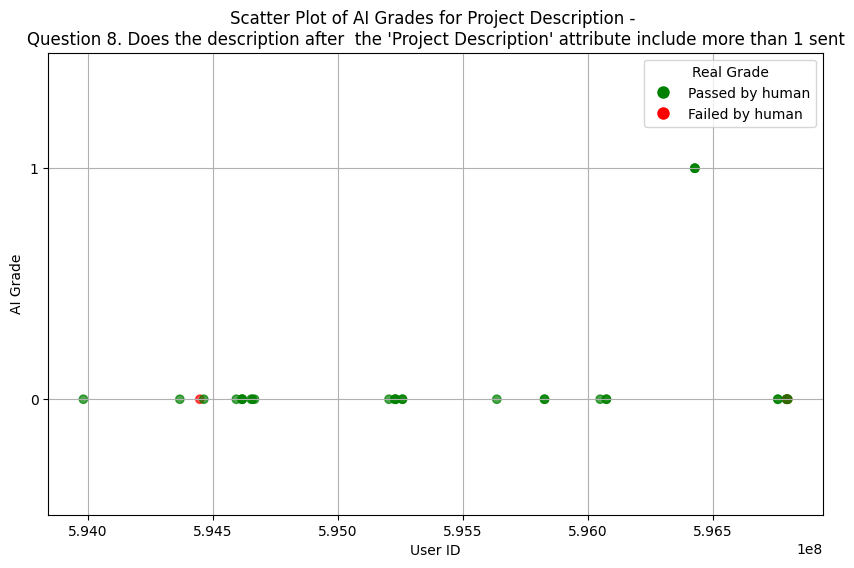

In [165]:
# Example usage
test_url = 'test_results/test_result_on_54_files_description_only_v4.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'
plot_section_criteria_scatter(test_url,real_url,'Project Description')

In [166]:
test_url = 'test_results/test_result_on_54_files_description_only_v4.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)
visualizer.check_grades('Project Description')

Number of unique file:  54
----------------------------------------
User ID: 593636371

Section: Project Description
Criteria: Question 5. Does the name of the 'TIP 2.0 Process Milestone:' attribute provide specific process milestone details? This is an example with grade 1: 'TIP 2.0 Process Milestone: Milestone 1.5 Health Equity'. This is an example with grade 1: 'TIP 2.0 Process Milestone: 5D: Identify health inequities'. This is an example with grade 0: 'TIP 2.0 Process Milestone: '. This is an example with grade 0: 'TIP 2.0 Process Milestone: Milestone 1.5'. This is an example with grade 0: 'TIP 2.0 Process Milestone: Health Equity'.
AI Grade: 0
AI Comment: The name of the 'TIP 2.0 Process Milestone:' attribute does not provide specific process milestone details. It only provides information about the organization's representative submitting a project online.
Human Grade: 1.0
Human Comment: I see a clear project description and purpose statement with enough detail.


Section: Proje

In [167]:
visualizer.plot_failed_submissions('Project Description')

Number of file:  54
----------------------------------------
user id: 593758154
Human Grade: 0.0
Human Comment: I see a somewhat clear project description and purpose statement with some detail. I recommend more background detail and a clear purpose statement like "The purpose of this project is to implement the PRAPARE screening tool". 

Section: Project Description
Criteria: Question 1. Is there any value of 'Project Name:' attribute exist? This is an example with grade 1: 'Project Name: Project X'. This is an example with grade 0: 'Project Name: '
AI Grade: 1
AI Comment: The value of the 'Project Name:' attribute exists and is 'PRAPARE Tool for Screening Health-Related Social Needs', which meets the criteria.

Section: Project Description
Criteria: Question 2. Does the value of the 'Clinic:' attribute exist? This is an example with grade 1: 'Clinic: Clinic X'. This is an example with grade 0: 'Clinic: '
AI Grade: 1
AI Comment: The value of the 'Clinic:' attribute exists and is 'The 

In [168]:
ver4 = pd.read_csv('test_results/test_result_on_54_files_description_only_v4.csv')
ver4

,Unnamed: 0,File_Name,AI_Grade,Comment,Section,Criteria
0,1,593636371,1,The value of the 'Project Name:' attribute exi...,Project Description / Purpose,Question 1. Is there any value of 'Project Nam...
1,2,593636371,1,The value of the 'Clinic:' attribute exists an...,Project Description / Purpose,Question 2. Does the value of the 'Clinic:' at...
2,3,593636371,1,The value of the 'Process:' attribute exists a...,Project Description / Purpose,Question 3. Does the value of the 'Process:' a...
3,4,593636371,1,The name of the 'TIP 2.0 Process Milestone:' a...,Project Description / Purpose,Question 4. Does the name of the 'TIP 2.0 Proc...
4,5,593636371,0,The name of the 'TIP 2.0 Process Milestone:' a...,Project Description / Purpose,Question 5. Does the name of the 'TIP 2.0 Proc...
...,...,...,...,...,...,...
427,4,596799191,0,Although the 'TIP 2.0 Process Milestone:' attr...,Project Description / Purpose,Question 4. Does the name of the 'TIP 2.0 Proc...
428,5,596799191,0,The 'TIP 2.0 Process Milestone:' attribute doe...,Project Description / Purpose,Question 5. Does the name of the 'TIP 2.0 Proc...
429,6,596799191,1,The description after the 'Project Description...,Project Description / Purpose,Question 6. Does the description after the 'Pr...
430,7,596799191,1,The description after the 'Project Description...,Project Description / Purpose,Question 7. Does the description after of the...


In [169]:
ver4['AI_Grade'].unique()

array([1, 0], dtype=int64)

# Visualize version 5

Number of files: 55


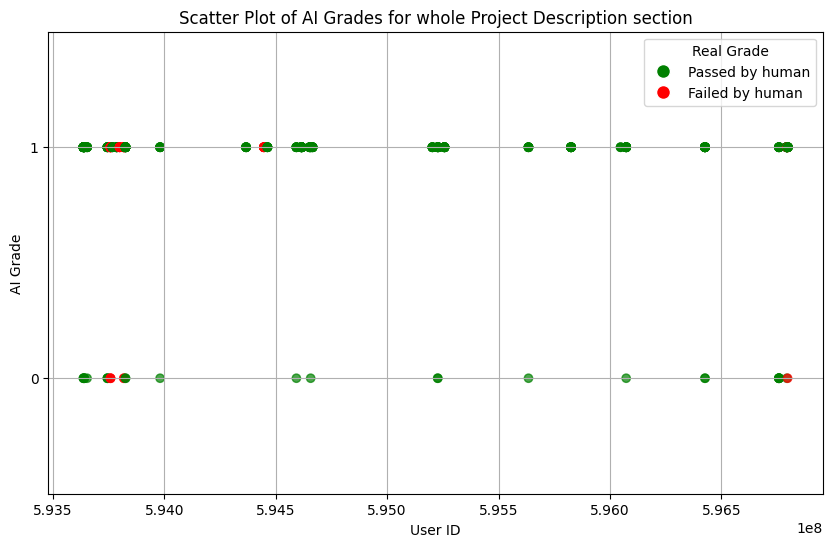

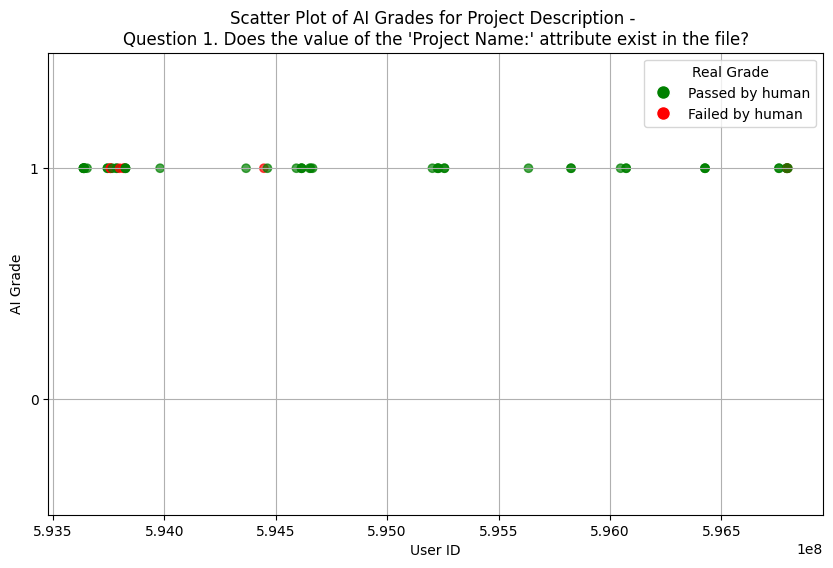

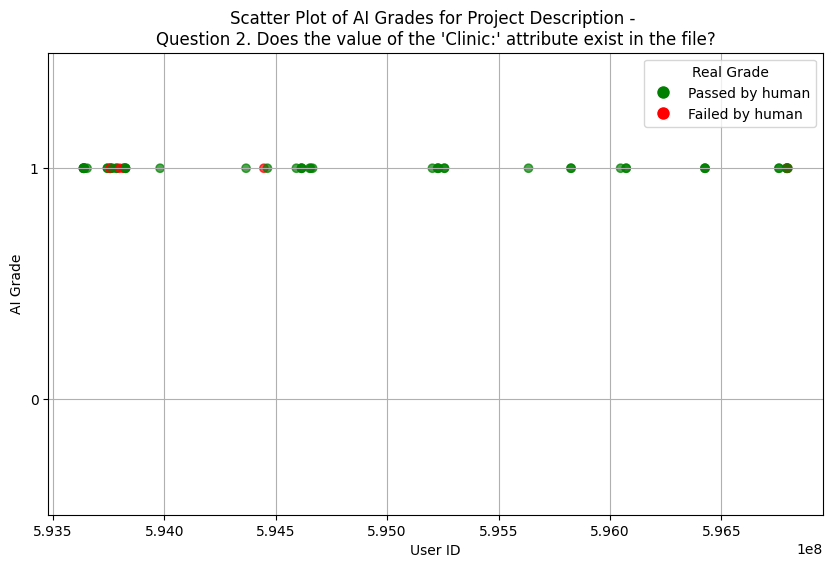

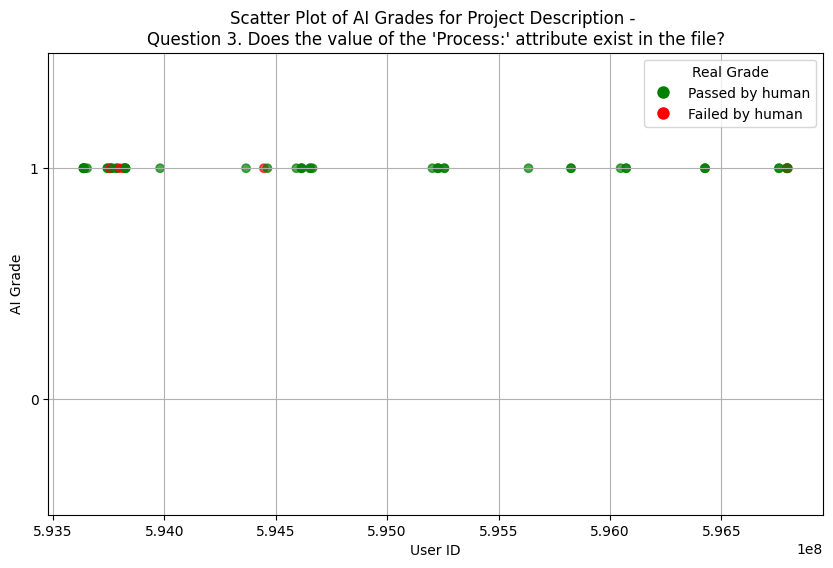

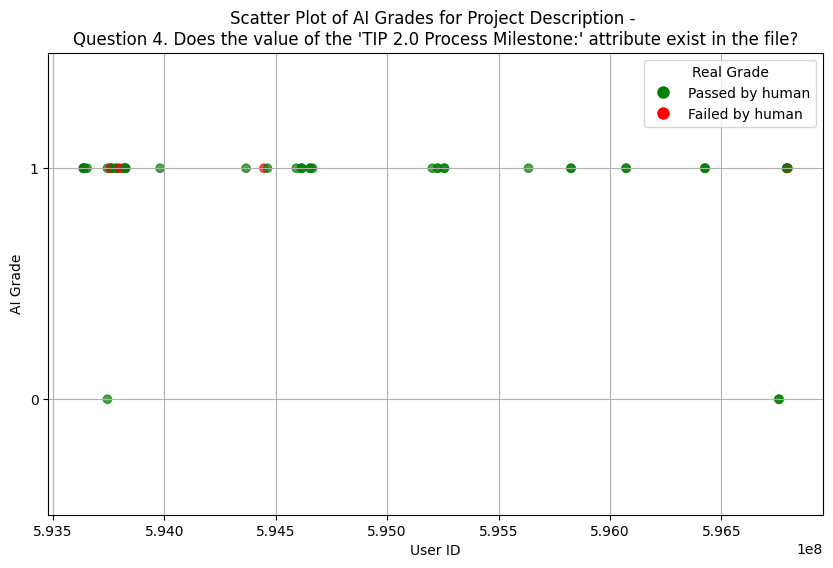

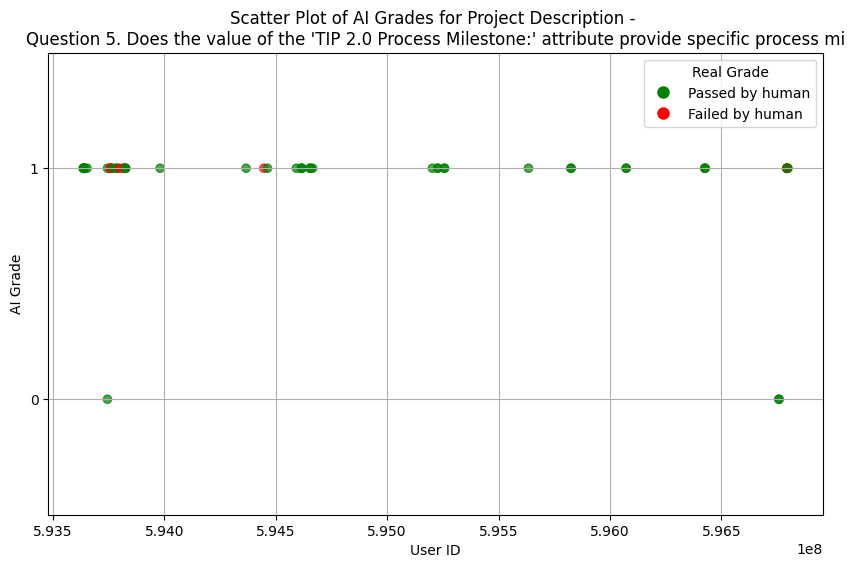

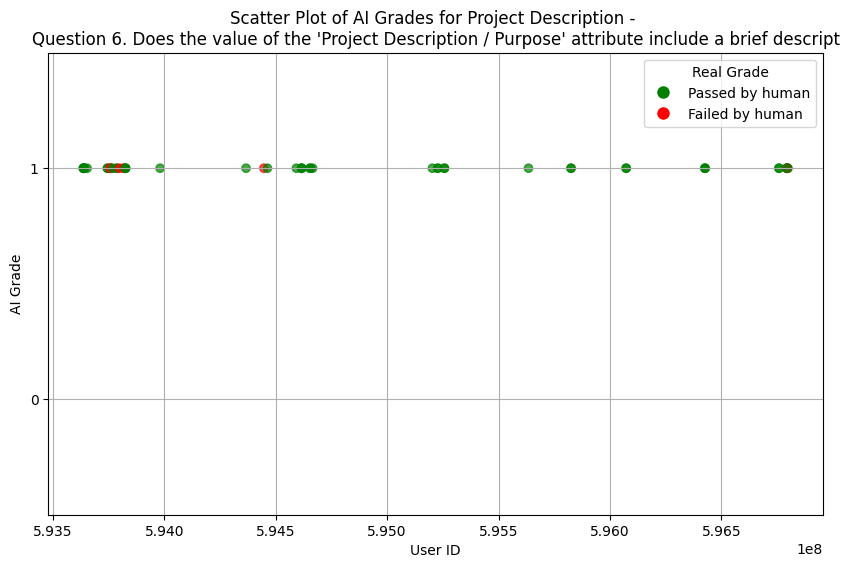

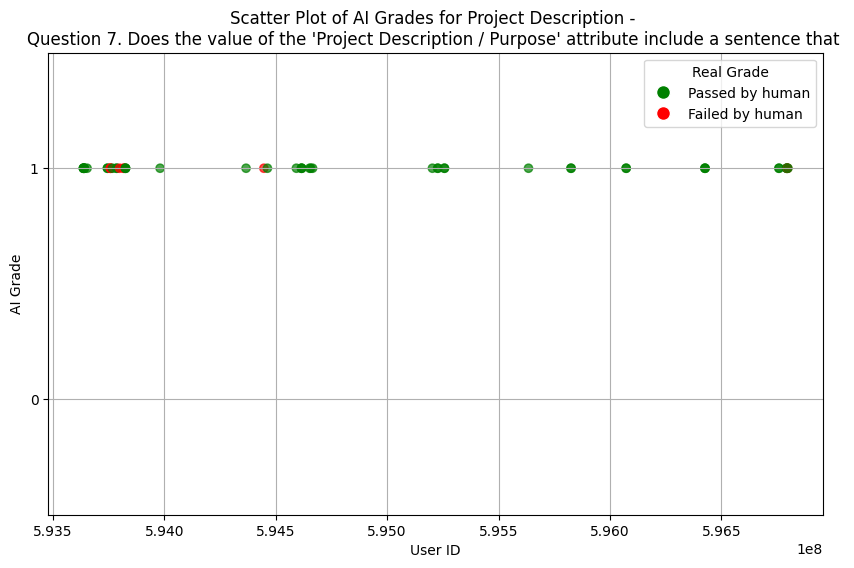

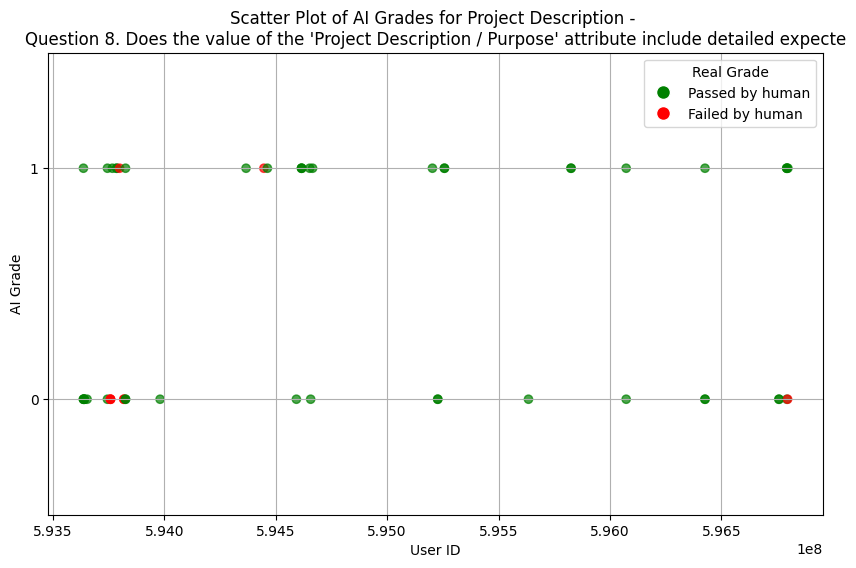

In [170]:
# Example usage
test_url = 'test_results/test_result_on_55_files_v5.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'
plot_section_criteria_scatter(test_url,real_url,'Project Description')

In [171]:
test_url = 'test_results/test_result_on_55_files_v5.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)
visualizer.plot_failed_submissions('Project Description')

Number of unique file:  55
Number of file:  55
----------------------------------------
user id: 593758154
Human Grade: 0.0
Human Comment: I see a somewhat clear project description and purpose statement with some detail. I recommend more background detail and a clear purpose statement like "The purpose of this project is to implement the PRAPARE screening tool". 

Section: Project Description
Criteria: Question 1. Does the value of the 'Project Name:' attribute exist in the file?
AI Grade: 1
AI Comment: There is a valid value for 'Project Name:' in the input.

Section: Project Description
Criteria: Question 2. Does the value of the 'Clinic:' attribute exist in the file?
AI Grade: 1
AI Comment: There is a valid value for 'Clinic:' in the input.

Section: Project Description
Criteria: Question 3. Does the value of the 'Process:' attribute exist in the file?
AI Grade: 1
AI Comment: There is a valid value for 'Process:' in the input.

Section: Project Description
Criteria: Question 4. Doe

# Version 6

In [172]:
test_url = 'test_results/test_result_on_55_files_v6.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)
visualizer.plot_failed_submissions('Project Description')

Number of unique file:  55
Number of file:  55
----------------------------------------
user id: 593758154
Human Grade: 0.0
Human Comment: I see a somewhat clear project description and purpose statement with some detail. I recommend more background detail and a clear purpose statement like "The purpose of this project is to implement the PRAPARE screening tool". 

Section: Project Description
Criteria: Question 1. Is the Project Name exist and enough to describe the project?
AI Grade: 1
AI Comment: The Project Name is provided and enough to describe the project.

Section: Project Description
Criteria: Question 2. Is the Clinic name exist and tell the clinic names?
AI Grade: 1
AI Comment: The Clinic name, The Guidance Center, is provided.

Section: Project Description
Criteria: Question 3. Is the Process name exist and tell the process names?
AI Grade: 1
AI Comment: The Process name, Utilizing the PRAPARE tool, is provided.

Section: Project Description
Criteria: Question 4. Is the TIP

# Version 7

In [195]:
test_url = 'test_results/test_result_on_55_files_v7.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)
visualizer.plot_false_positive('Project Description')

Number of unique file:  55
Number of false positive:  1
----------------------------------------
user id: 594446674
Human Grade: 0.0
Human Comment: I do not see enough detail about the project description and purpose statement. I recommend a clear statement like "The purpose of this project is to implement a ...". 

Section: Project Description
Criteria: Question 1. Is the Project name exist and enough to describe the project?
AI Grade: 1
AI Comment: The Project name is clearly stated and enough to describe the project.

Section: Project Description
Criteria: Question 2. Is the Clinic name exist and tell the clinic names?
AI Grade: 1
AI Comment: The Clinic name is explicitly mentioned as 'Arbor Medical Partner practices'.

Section: Project Description
Criteria: Question 3. Is the Process name exist and tell the process names?
AI Grade: 1
AI Comment: The Process name is described as 'Distribution of screening tool, documentation of results, and closed loop referral process for needed co

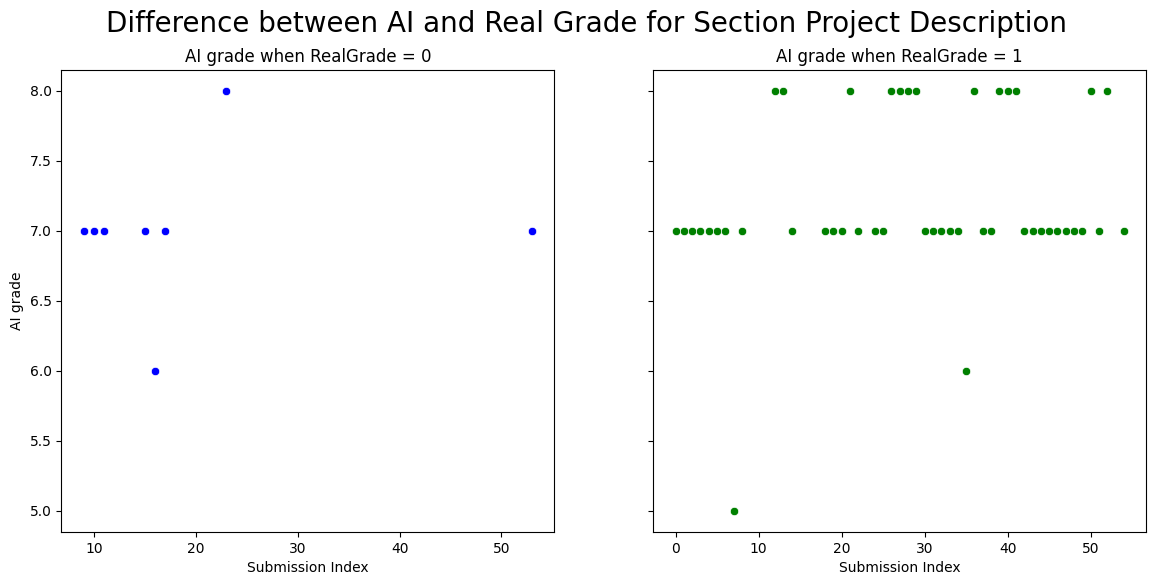

In [196]:
visualizer.visualize_difference_between_AI_and_Real_Grade('Project Description')

In [197]:
visualizer.plot_false_negative('Project Description')

Number of false positive:  34
----------------------------------------
user id: 593636371
Human Grade: 1.0
Human Comment: I see a clear project description and purpose statement with enough detail.


Section: Project Description
Criteria: Question 1. Is the Project name exist and enough to describe the project?
AI Grade: 1
AI Comment: The Project name is clearly stated and enough to describe the project.

Section: Project Description
Criteria: Question 2. Is the Clinic name exist and tell the clinic names?
AI Grade: 1
AI Comment: The Clinic name, EMPACT-Suicide Prevention Center, is explicitly mentioned.

Section: Project Description
Criteria: Question 3. Is the Process name exist and tell the process names?
AI Grade: 1
AI Comment: The Process name, Implementation of PRAPARE Screening Tool and documenting results in Medical Record, is clearly stated.

Section: Project Description
Criteria: Question 4. Is the TIP 2.0 Milestone exist and tell the milestone?
AI Grade: 1
AI Comment: The TI